In [1]:
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import urllib.request
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/nshaud/ml_for_astro/main/stars.csv", "stars.csv")
df_stars = pd.read_csv("stars.csv")
df_stars.values[:,:4]

array([[3068, 0.0024, 0.17, 16.12],
       [3042, 0.0005, 0.1542, 16.6],
       [2600, 0.0003, 0.102, 18.7],
       [2800, 0.0002, 0.16, 16.65],
       [1939, 0.000138, 0.103, 20.06],
       [2840, 0.00065, 0.11, 16.98],
       [2637, 0.00073, 0.127, 17.22],
       [2600, 0.0004, 0.096, 17.4],
       [2650, 0.00069, 0.11, 17.45],
       [2700, 0.00018, 0.13, 16.05],
       [3600, 0.0029, 0.51, 10.69],
       [3129, 0.0122, 0.3761, 11.79],
       [3134, 0.0004, 0.196, 13.21],
       [3628, 0.0055, 0.3929999999999999, 10.48],
       [2650, 0.0006, 0.14, 11.782],
       [3340, 0.0038, 0.24, 13.07],
       [2799, 0.0018, 0.16, 14.79],
       [3692, 0.00367, 0.47, 10.8],
       [3192, 0.00362, 0.1967, 13.53],
       [3441, 0.039, 0.351, 11.18],
       [25000, 0.0559999999999999, 0.0084, 10.58],
       [7740, 0.00049, 0.01234, 14.02],
       [7220, 0.0001699999999999, 0.011, 14.23],
       [8500, 0.0005, 0.01, 14.5],
       [16500, 0.013, 0.0139999999999999, 11.89],
       [12990, 8.49999999

In [3]:
le = LabelEncoder()
# Assign unique integers from 0 to 6 to each star type
df_stars['Star type'] = le.fit_transform(df_stars['Star type'])
labels = le.inverse_transform(df_stars['Star type'])
class_names = le.classes_
print(class_names)

['Brown Dwarf' 'Hypergiant' 'Main Sequence' 'Red Dwarf' 'Supergiant'
 'White Dwarf']


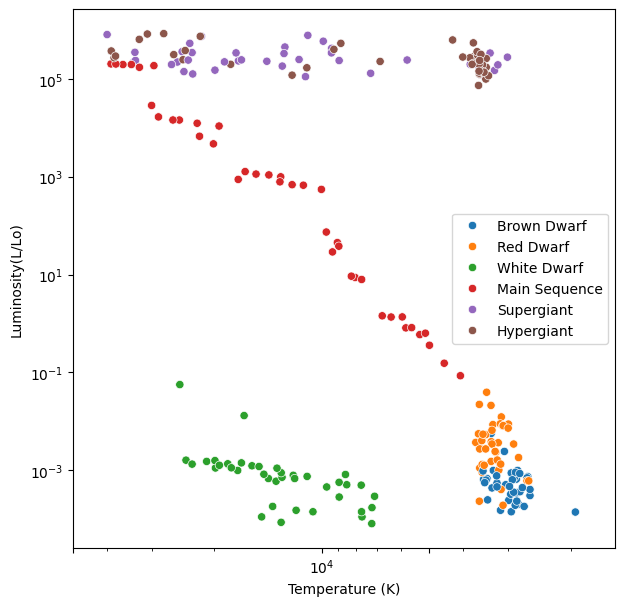

In [4]:
plt.figure(figsize=(7, 7))
sns.scatterplot(data=df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue=labels)
plt.xscale('log')
plt.yscale('log')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)
plt.show()

In [5]:
# Compute PCA

n_components = 4

# use Randomized PCA for speed
# pca = RandomizedPCA(n_components)
pca = PCA(n_components, svd_solver='randomized')
pca.fit(df_stars.values[:,:4])
evals = pca.explained_variance_ratio_ 
print('Expained fractional variance of data encapsulated in the eigenvalues: ' + str(evals))

Expained fractional variance of data encapsulated in the eigenvalues: [9.97606313e-01 2.38789920e-03 5.78677260e-06 1.34274189e-09]


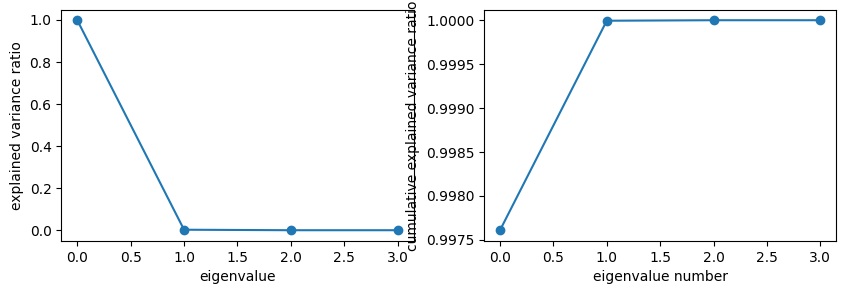

In [6]:
fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(121)

ax.plot(np.arange(n_components), evals)
ax.scatter(np.arange(n_components), evals)

ax.set_xlabel("eigenvalue")
ax.set_ylabel("explained variance ratio")

ax = fig.add_subplot(122)

ax.plot(np.arange(n_components), evals.cumsum())
ax.scatter(np.arange(n_components), evals.cumsum())

ax.set_xlabel("eigenvalue number")
ax.set_ylabel("cumulative explained variance ratio")

plt.show()

In [7]:
for num_feats in np.arange(1,20, dtype = int):
    best_pca = PCA(n_components=num_feats)
    best_pca.fit(df_stars.values[:,:4])
    if (sum(best_pca.explained_variance_ratio_)>0.995):
        break
print("{:d} features are needed to explain 99.5% of the variance".format(num_feats))

1 features are needed to explain 99.5% of the variance


In [8]:
eigenvectors = pca.components_
eigenvectors.shape

(4, 4)

In [9]:
plt.figure(figsize=(7, 7))
sns.scatterplot(x=pca.components_[:,0], y=pca.components_[:,1], hue=labels)

ValueError: All arrays must be of the same length

<Figure size 700x700 with 0 Axes>